In [1]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt

import hist
import scipy
from scipy import optimize

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/df_test_sample_hard_scattering/"
savedir = "/home/chardong/y_identification/Venv/save_plots/"

In [3]:
df = pd.read_pickle(datadir+"df_test_combined_sample_hard_scattering_skim30.pkl")
#df.head()

In [4]:
# y_eta
edges_eta = [0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37]

# y_pt
edges_pt_bkg = [20,  25,  30,  35,  40,  45, 50, 65, 490]
edges_pt_sig = edges_pt_bkg

# evt-mu
edges_mu_bkg =  [0., 16., 22., 24., 26., 28., 30., 32., 34., 36., 40., 44., 46., 48., 60]
#[5, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 40]
edges_mu_sig = edges_mu_bkg

# Créer des axes de structure de bins
axis_eta = hist.axis.Variable(edges_eta,    name="eta", label=r"$\eta$")

# Créer des axes de structure de bins
axis_pt_sig = hist.axis.Variable(edges_pt_sig, name='pt', label=r"$p_T$ [GeV]")
axis_pt_bkg = hist.axis.Variable(edges_pt_bkg, name='pt', label=r"$p_T$ [GeV]")

# Créer des axes de structure de bins
axis_mu_sig = hist.axis.Variable(edges_mu_sig, name='evt_mu', label=r"$evt_\mu$")
axis_mu_bkg = hist.axis.Variable(edges_mu_bkg, name='evt_mu', label=r"$evt_\mu$")

In [5]:
# Preselection on photon passin Loose cut-based selection 
df = df.query('y_IsLoose == 1')

In [6]:
# Adding column with absolute eta value, assuming symmetry
df['y_abs_eta'] = np.abs(df['y_eta'])
#df.head()

In [7]:
# Assiging indices correspoding to bins to each event in dataset
# Nouvelles colones eta_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(eta_bin = axis_eta.index(df['y_abs_eta']))

# Assiging indices correspoding to bins to each event in dataset
# Nouvelles colones pT_bin_.. dans le df assignant chaque valeur de pT à un bin de l'histograme axis_... 
df = df.assign(pt_bin_sig = axis_pt_sig.index(df['y_pt']))
df = df.assign(pt_bin_bkg = axis_pt_bkg.index(df['y_pt']))

# Assiging indices correspoding to bins to each event in dataset
df = df.assign(mu_bin_sig = axis_mu_sig.index(df['evt_mu']))       #Mapper les valeur de evt_mu aux bins définis par axis_mu_sig.
df = df.assign(mu_bin_bkg = axis_mu_bkg.index(df['evt_mu']))
#df.head()

In [8]:
df_sig = df.query('truth_label==1')
df_bkg = df.query('truth_label==0')

print(f'    Signal dataset size = {len(df_sig):7d}')
print(f'Background dataset size = {len(df_bkg):7d}')

    Signal dataset size = 2301038
Background dataset size =  186284


In [9]:
df_sig_tight = df_sig[(df_sig["y_IsTight"]==1)]  #bouléen
df_bkg_tight = df_bkg[(df_bkg["y_IsTight"]==1)]

print(f'    Signal dataset size = {len(df_sig_tight):7d}')
print(f'Background dataset size = {len(df_bkg_tight):7d}')

    Signal dataset size = 2132650
Background dataset size =   39568


### Compute efficiency and rejection for cut-based Tight identification

In [10]:
# Histograms and Axes pour 'mu', 'pt' et 'eta'

den_sig = hist.Hist(axis_eta, axis_pt_sig, axis_mu_sig).fill(df_sig["y_abs_eta"], df_sig["y_pt"], df_sig["evt_mu"])   #before cut-base
den_bkg = hist.Hist(axis_eta, axis_pt_bkg, axis_mu_bkg).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"], df_bkg["evt_mu"])


num_sig_tight = hist.Hist(axis_eta, axis_pt_sig, axis_mu_sig).fill(df_sig_tight["y_abs_eta"], 
                                                                       df_sig_tight["y_pt"], df_sig_tight["evt_mu"])   #after cut-base
num_bkg_tight = hist.Hist(axis_eta, axis_pt_bkg, axis_mu_bkg).fill(df_bkg_tight["y_abs_eta"], 
                                                                       df_bkg_tight["y_pt"], df_bkg_tight["evt_mu"])

eff_sig_tight = (num_sig_tight/den_sig).values()
efferr_sig_tight = np.sqrt(eff_sig_tight*(1.-eff_sig_tight)/den_sig.values()) # binomial uncertainty on efficiency

eff_bkg_tight = (num_bkg_tight/den_bkg).values()
efferr_bkg_tight = np.sqrt(eff_bkg_tight*(1.-eff_bkg_tight)/den_bkg.values()) # binomial uncertainty on efficiency

## eff_sig_XXX : (ETA, PT, MU)

# BDT working point optimization

In [11]:
def compute_eff_BDT(df, threshold):
    '''Return efficienty of a given selection on BDT score'''
    r = (df['Original_signal_score'] > threshold).sum() / len(df)
    return r

In [12]:
def find_cut_with_root_scalar(df, target_efficiency):
    '''Find selection on BDT score correponsing to target effeciency'''
    r = scipy.optimize.root_scalar(
        lambda x: compute_eff_BDT(df, x) - target_efficiency, bracket=(0., 1.0), 
        method='brenth', options={'xtol': 1E-5, 'maxiter': 50}
    )
    return r.root

In [13]:
#df_bkg.head()

In [14]:
df_bkg_indexed = df_bkg.set_index(['mu_bin_bkg', 'pt_bin_bkg', 'eta_bin']).sort_index()
df_bkg_indexed

y_pt     y_eta     y_phi  y_convRadius  \
mu_bin_bkg pt_bin_bkg eta_bin                                                
0          0          0        23.172302  0.544748  0.812935   9999.000000   
                      0        23.922916  0.480620  1.075017     36.265739   
                      0        22.555389 -0.539696  2.383196   9999.000000   
                      0        23.910772  0.164627 -1.852649     89.606613   
                      0        22.400295  0.528513  2.170370    296.497345   
...                                  ...       ...       ...           ...   
14         7          7        72.417625  2.058916 -1.865030   9999.000000   
                      7        83.246689 -2.345259 -1.050470     94.960258   
                      7        94.037430 -2.233927  0.532729   9999.000000   
                      8        69.574806 -2.376270 -1.291363    136.820160   
                      8        74.508057 -2.370181 -1.905103   9999.000000   

                               y_convType       weight  truth_label  evt_mu  \
mu_bin_bkg pt_bin_bkg eta_bin                                                 
0          0          0                 0   843.163940          0.0   14.49   
                      0                 3   340.742513          0.0    8.50   
                      0                 0  5354.811757          0.0   13.49   
                      0                 3   113.699228          0.0    4.50   
                      0                 1  8707.345311          0.0   14.49   
...                                   ...          ...          ...     ...   
14         7          7                 0     1.263899          0.0   65.50   
                      7                 1     0.000000          0.0   80.50   
                      7                 0     0.000000          0.0   85.50   
                      8                 1     0.685169          0.0   64.50   
                      8                 0     0.000000          0.0   92.50   

                               y_IsLoose  y_IsTight  y_truth_pt  y_truth_eta  \
mu_bin_bkg pt_bin_bkg eta_bin                                                  
0          0          0             True      False   16.249475     0.521072   
                      0             True      False   10.706585     0.480694   
                      0             True      False   19.790754    -0.539809   
                      0             True      False -999.000000  -999.000000   
                      0             True      False   10.428835     0.528653   
...                                  ...        ...         ...          ...   
14         7          7             True       True   69.046707     2.059837   
                      7             True       True   44.333076    -2.346262   
                      7             True      False   62.275867    -2.231258   
                      8             True       True   50.108772    -2.375190   
                      8             True      False   49.268169    -2.372822   

                               Original_background_score  \
mu_bin_bkg pt_bin_bkg eta_bin                              
0          0          0                         0.911685   
                      0                         0.995991   
                      0                         0.752417   
                      0                         0.867384   
                      0                         0.995931   
...                                                  ...   
14         7          7                         0.039097   
                      7                         0.604148   
                      7                         0.142775   
                      8                         0.054820   
                      8                         0.550190   

                               Original_signal_score  \
mu_bin_bkg pt_bin_bkg eta_bin                          
0          0          0                     0.088315   
   

In [15]:
bdt_cut_same_background_efficiency_tight = {} # store optimal BDT thresholds

for (ieta, ipt, imu), eff_tight in np.ndenumerate(eff_bkg_tight): 
    # select subsample of events corresponding to the current (eta,mu) bin
    
    df_bin = df_bkg_indexed.loc[imu, ipt, ieta] # using indexed df to speedup selection
    
    # find and store optimal BDT selection for current bin
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency = eff_tight)
    bdt_cut_same_background_efficiency_tight[imu, ipt, ieta] = cut_BDT

bdt_cut_same_background_efficiency_tight = pd.Series(bdt_cut_same_background_efficiency_tight).sort_index()
bdt_cut_same_background_efficiency_tight.index.names = ['mu_bin_bkg', 'pt_bin_bkg', 'eta_bin']

bdt_cut_same_background_efficiency_tight

mu_bin_bkg  pt_bin_bkg  eta_bin
0           0           0          0.781734
                        1          0.772287
                        2          0.776044
                        3          0.660955
                        4          0.750000
                                     ...   
13          7           3          0.670966
                        4          0.467452
                        5          0.585730
                        6          0.798227
                        7          0.756970
Length: 896, dtype: float64

In [16]:
df = df.merge(bdt_cut_same_background_efficiency_tight.rename('BDTcut_samebkgeff_tight'), 
             on=['mu_bin_bkg', 'pt_bin_bkg', 'eta_bin'], how="left")
df = df.assign(pass_BDTcut_samebkgeff_tight = df['Original_signal_score'] > df['BDTcut_samebkgeff_tight'])

In [17]:
df.drop('BDTcut_samebkgeff_tight',axis=1,inplace=True)

In [18]:
df.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,...,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,eta_bin,pt_bin_sig,pt_bin_bkg,mu_bin_sig,mu_bin_bkg,pass_BDTcut_samebkgeff_tight
0,39.007401,0.172711,-0.628337,9999.0,0,554.386153,1.0,29.5,True,True,...,0.973711,0.031017,0.968983,0.172711,0,3,3,5,5,True
1,86.679977,0.162386,2.113541,9999.0,0,40.708948,1.0,22.5,True,True,...,0.970001,0.030308,0.969692,0.162386,0,7,7,2,2,True
2,281.008636,-0.796674,0.281347,9999.0,0,0.283104,1.0,28.5,True,True,...,0.979235,0.022537,0.977463,0.796674,1,7,7,5,5,True
3,59.986805,-1.329535,1.144537,9999.0,0,94.620789,1.0,42.5,True,False,...,0.972958,0.030241,0.969759,1.329535,3,6,6,10,10,True
4,401.259369,0.836519,-1.640876,9999.0,0,0.639481,1.0,54.5,True,True,...,0.980670,0.022041,0.977959,0.836519,2,7,7,13,13,True


### Compute efficiency and rejection for BDT working point

In [19]:
df_sig = df.query('truth_label == 1')
df_bkg = df.query('truth_label == 0')

In [20]:
#num and efficiency for the BDT

df_sig_bdt = df_sig.query('pass_BDTcut_samebkgeff_tight')
num_sig_bdt = hist.Hist(axis_eta, axis_pt_sig, axis_mu_sig).fill(df_sig_bdt["y_abs_eta"], 
                                                                     df_sig_bdt["y_pt"], df_sig_bdt["evt_mu"])

df_bkg_bdt = df_bkg.query('pass_BDTcut_samebkgeff_tight')
num_bkg_bdt = hist.Hist(axis_eta, axis_pt_bkg, axis_mu_bkg).fill(df_bkg_bdt["y_abs_eta"], 
                                                                     df_bkg_bdt["y_pt"], df_bkg_bdt["evt_mu"])

eff_sig_bdt = (num_sig_bdt / den_sig).values()
efferr_sig_bdt = np.sqrt(eff_sig_bdt * (1 - eff_sig_bdt) / den_sig.values())

eff_bkg_bdt = (num_bkg_bdt / den_bkg).values()
efferr_bkg_bdt = np.sqrt(eff_bkg_bdt * (1 - eff_bkg_bdt) / den_bkg.values())

In [21]:
# Convertir les histogrammes en listes ou arrays pour tracer avec matplotlib
mu_sig = axis_mu_sig.centers
mu_bkg = axis_mu_bkg.centers

In [22]:
print(eff_sig_tight.shape) 
print()
print(type(eff_sig_tight)) 
print()
# Longueur de la première dimension
first_dim_length = eff_sig_tight.shape[0]
print(f"Longueur de la première dimension Eta : {first_dim_length}")
print()
# Longueur de la deuxième dimension
second_dim_length = eff_sig_tight.shape[1]
print(f"Longueur de la deuxième dimension pT : {second_dim_length}")
print()
# Longueur de la troisième dimension
third_dim_length = eff_sig_tight.shape[2]
print(f"Longueur de la troisième dimension Mu : {third_dim_length}")
print()
print(mu_sig) 
print()
# Accéder à la première tranche de la troisième dimension
first_slice = eff_sig_tight[:, :, 0]
print(f"Première tranche de la troisième dimension :\n{first_slice}")

(8, 8, 14)

<class 'numpy.ndarray'>

Longueur de la première dimension Eta : 8

Longueur de la deuxième dimension pT : 8

Longueur de la troisième dimension Mu : 14

[ 8. 19. 23. 25. 27. 29. 31. 33. 35. 38. 42. 45. 47. 54.]

Première tranche de la troisième dimension :
[[0.88940092 0.8880597  0.83985765 0.91341991 0.93494229 0.94392523
  0.93251908 0.9428913 ]
 [0.84328358 0.85507246 0.89380531 0.90086207 0.92283951 0.95061728
  0.92335116 0.94956232]
 [0.80952381 0.83928571 0.87878788 0.88173456 0.93115942 0.9513382
  0.93640351 0.94154041]
 [0.90967742 0.91489362 0.832      0.90766208 0.94705882 0.91304348
  0.95162709 0.94460564]
 [0.75       0.42857143 0.66666667 0.92307692 0.73333333 0.84615385
  0.88095238 0.94480519]
 [0.845      0.85164835 0.83783784 0.90557276 0.90196078 0.88888889
  0.92936288 0.95311503]
 [0.9        0.94927536 0.88596491 0.92470588 0.95017794 0.95384615
  0.92610365 0.94788801]
 [0.89494163 0.9212963  0.90751445 0.937583   0.92364991 0.93041237
  0.93526405

# Mu into ETA & pT bin

## Agrégation sur la dimension pT
Pour la i_em colones de pT

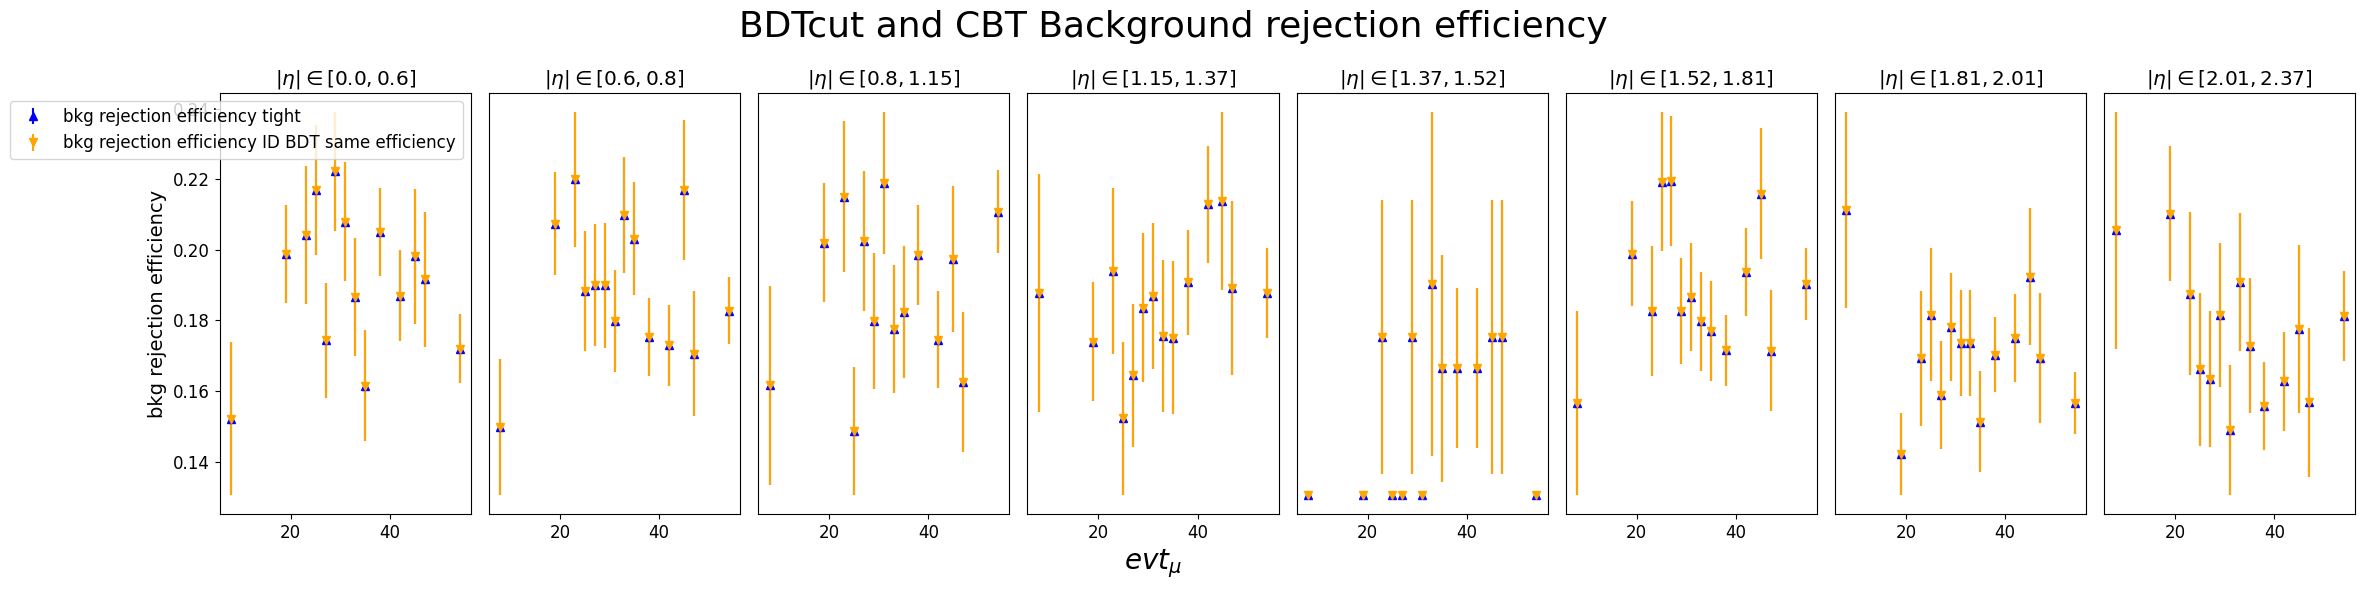

In [23]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

# Boucle pour les axes principaux
for i in range(8):
    # Erreurs et courbes pour eff_bkg_tight et eff_bkg_bdt
    ax[i].errorbar(mu_bkg, eff_bkg_tight[i, i, :], efferr_bkg_tight[i, i, :],
                   fmt="^", label='bkg rejection efficiency tight', color='blue')
    ax[i].errorbar(mu_bkg, eff_bkg_bdt[i, i, :], efferr_bkg_bdt[i, i, :],
                   fmt="v", label='bkg rejection efficiency ID BDT same efficiency', color='orange')
    if i != 0:
        ax[i].set_yticks([])
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set_title(text)
    
# Ajout des labels et légendes
ax[0].set_ylabel("bkg rejection efficiency", fontsize=14)
ax[3].set_xlabel("$evt_{\mu}$", fontsize=20)
ax[0].legend(fontsize=12)
fig.suptitle('BDTcut and CBT Background rejection efficiency', fontsize=26)

plt.tight_layout()

plt.show()

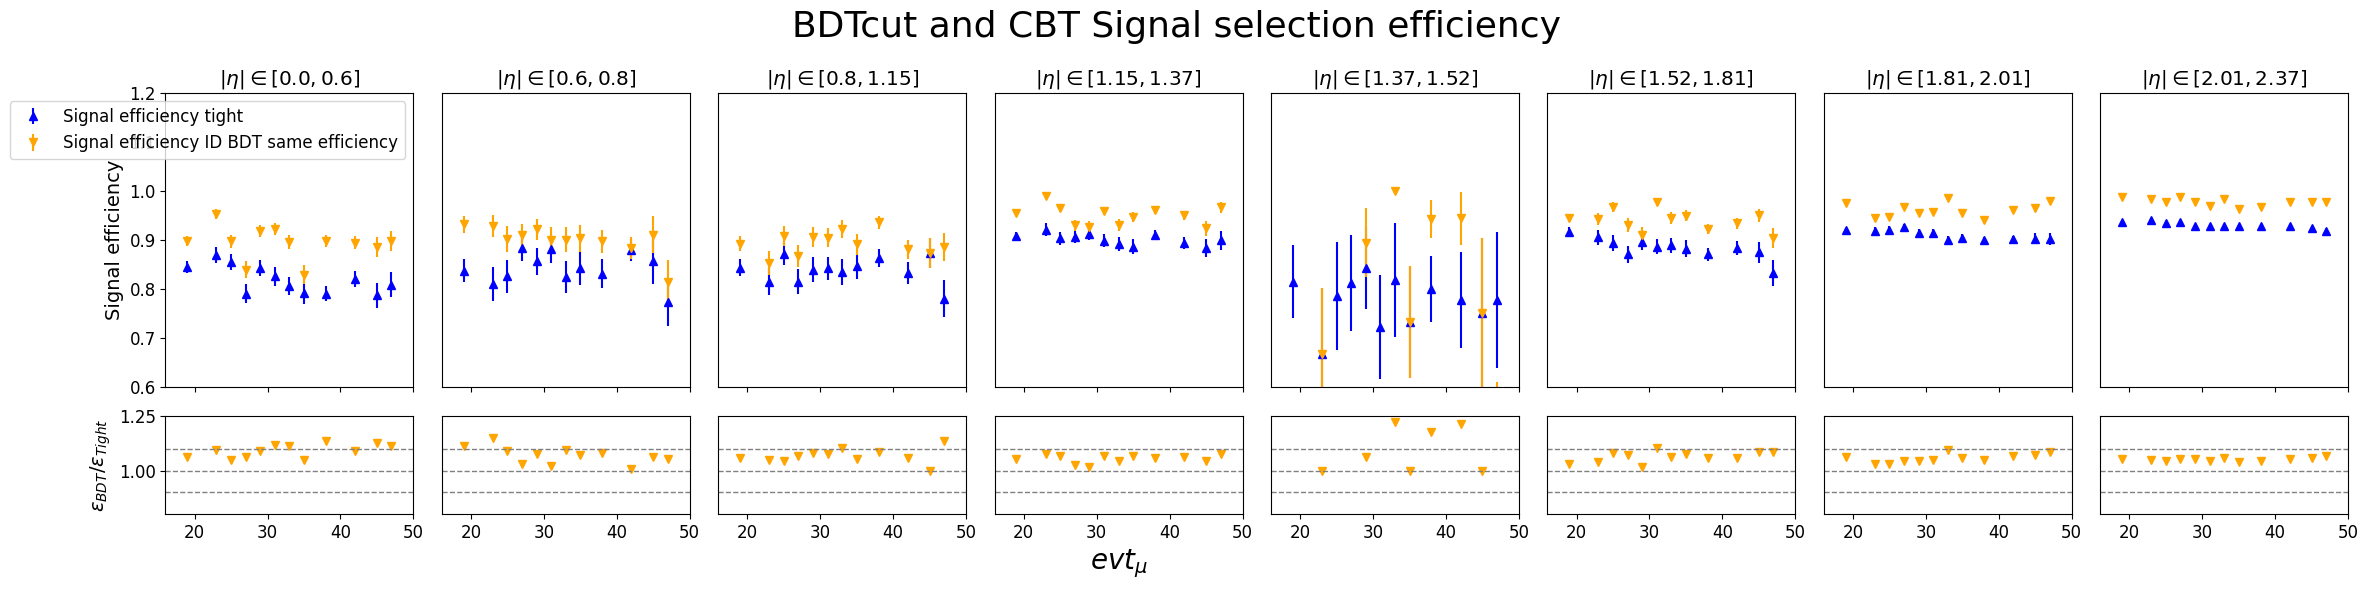

In [24]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24, 6),
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace=0, hspace=0)

# Boucle pour les axes principaux
for i in range(8):
    # Erreurs et courbes pour eff_sig_tight et eff_sig_bdt
    ax[i].errorbar(mu_sig, eff_sig_tight[i, i, :], efferr_sig_tight[i, i, :],
                   fmt="^", label='Signal efficiency tight', color='blue')
    ax[i].errorbar(mu_sig, eff_sig_bdt[i, i, :], efferr_sig_bdt[i, i, :],
                   fmt="v", label='Signal efficiency ID BDT same efficiency', color='orange')
    if i != 0:
        ax[i].set_yticks([])
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set_title(text)
    
    # Ratio des efficacités
    rax[i].plot(mu_sig, eff_sig_bdt[i, i, :] / eff_sig_tight[i, i, :], 'v', color='orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 50])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.6, 1.2])
    if i != 0:
        rax[i].set_yticks([])

# Ajout des labels et légendes
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency", fontsize=14)
rax[3].set_xlabel("$evt_{\mu}$", fontsize=20)
ax[0].legend(fontsize=12)

fig.suptitle('BDTcut and CBT Signal selection efficiency', fontsize=26)

plt.tight_layout()

plt.show()

In [25]:
eff_sig_tight[i, 5]

array([0.93041237, 0.93023256, 0.91304348, 0.92703863, 0.92477876,
       0.91777778, 0.88139059, 0.92066806, 0.91578947, 0.91642651,
       0.87740806, 0.89956332, 0.8600823 , 0.86636467])

In [26]:
eta_idx = 7  # bin de eta
mu_idx = 7   # bin de mu

# Accéder aux valeurs d'efficacité pour les indices fixes de eta et mu
eff_values_pt = eff_sig_tight[eta_idx, :, ]

# Afficher les valeurs d'efficacité pour pt
print(f"Valeurs d'efficacité de pt pour eta index {eta_idx} et mu index {mu_idx} :")
print(eff_values_pt)


Valeurs d'efficacité de pt pour eta index 7 et mu index 7 :
[[0.89494163 0.88675624 0.90047393 0.84186047 0.88709677 0.8880597
  0.88979592 0.84291188 0.85436893 0.85100287 0.81272085 0.80952381
  0.81060606 0.83135392]
 [0.9212963  0.88167053 0.85853659 0.89189189 0.89903846 0.85581395
  0.87946429 0.87551867 0.87078652 0.84385382 0.87218045 0.86507937
  0.88333333 0.83333333]
 [0.90751445 0.85371703 0.86592179 0.8826087  0.89805825 0.8680203
  0.88       0.86633663 0.87777778 0.91049383 0.8754717  0.88976378
  0.87628866 0.8515625 ]
 [0.937583   0.9278043  0.92959583 0.91808874 0.925      0.89007092
  0.90990991 0.89010989 0.8919708  0.89227166 0.88440367 0.86638831
  0.8790932  0.88454012]
 [0.92364991 0.90875233 0.93501048 0.90186125 0.91218638 0.91531532
  0.89247312 0.88454012 0.90233546 0.89506173 0.88335704 0.89891697
  0.88813559 0.87096774]
 [0.93041237 0.93023256 0.91304348 0.92703863 0.92477876 0.91777778
  0.88139059 0.92066806 0.91578947 0.91642651 0.87740806 0.89956332
 

## Agrégation sur la dimension pT
Moyenne sur la dimension pT :

In [27]:
# Copy
eff_bkg_tight_copy = np.copy(eff_bkg_tight)
efferr_bkg_tight_copy = np.copy(efferr_bkg_tight)
eff_bkg_bdt_copy = np.copy(eff_bkg_bdt)
efferr_bkg_bdt_copy = np.copy(efferr_bkg_bdt)

# Suppression de la dimension pT en prenant la moyenne sur cette dimension
eff_bkg_tight_2d = np.mean(eff_bkg_tight_copy, axis=1)
efferr_bkg_tight_2d = np.sqrt(np.sum(efferr_bkg_tight_copy**2, axis=1)) / np.sqrt(efferr_bkg_tight_copy.shape[1])
eff_bkg_bdt_2d = np.mean(eff_bkg_bdt_copy, axis=1)
efferr_bkg_bdt_2d = np.sqrt(np.sum(efferr_bkg_bdt_copy**2, axis=1)) / np.sqrt(efferr_bkg_bdt_copy.shape[1])

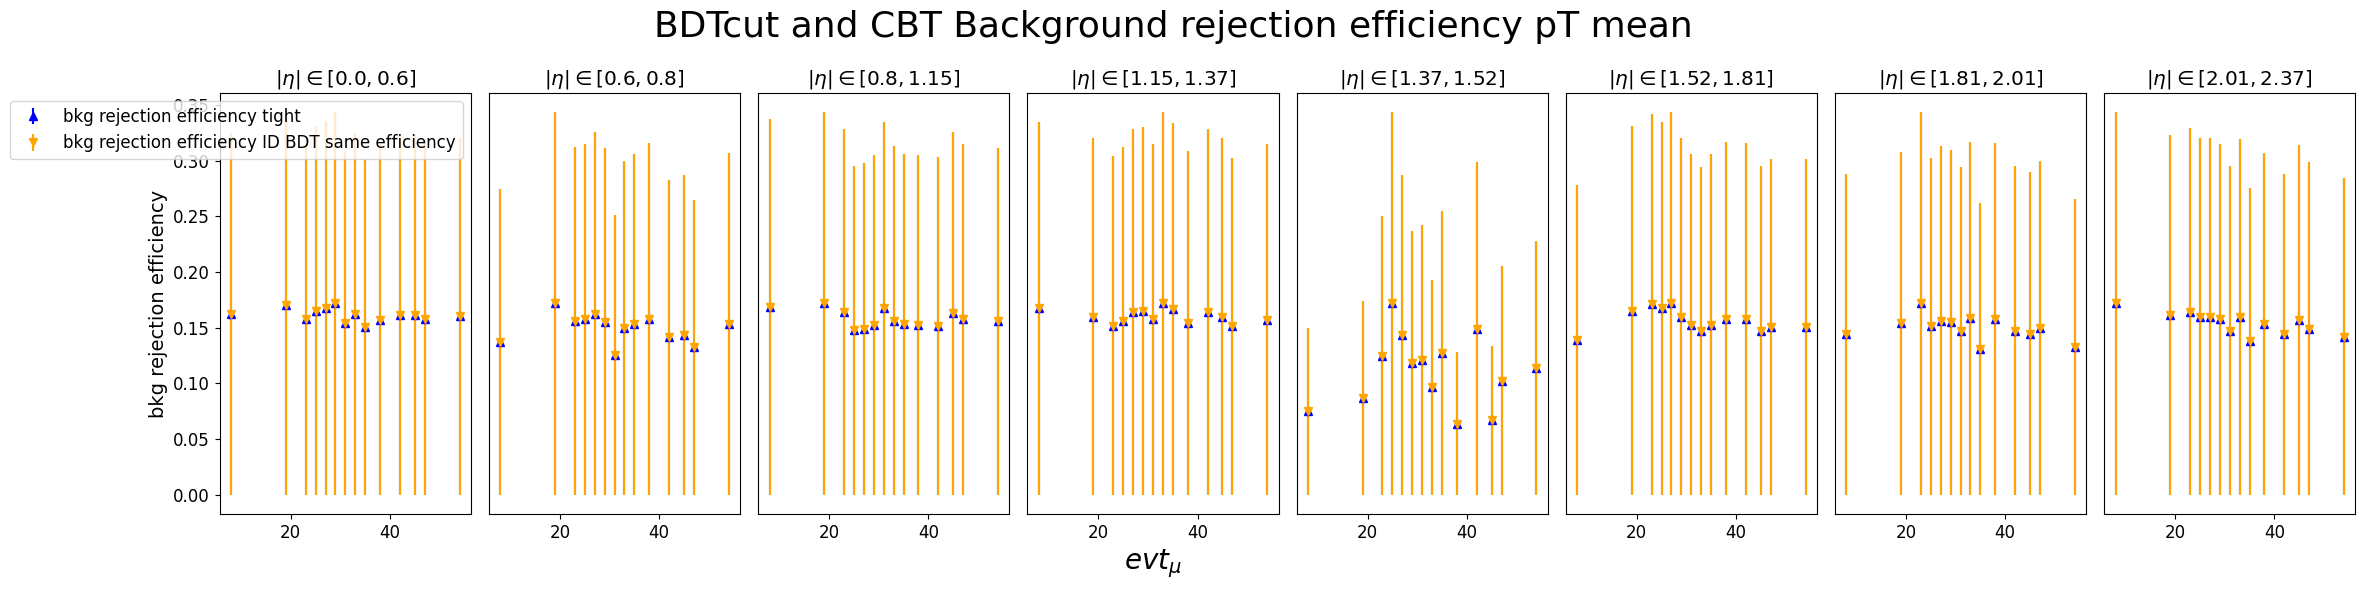

In [28]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,8))
fig.subplots_adjust(wspace =.0, hspace=.0)

# Boucle pour les axes principaux
for i in range(8):
    # Erreurs et courbes pour eff_bkg_tight et eff_bkg_bdt
    ax[i].errorbar(mu_bkg, eff_bkg_tight_2d[i], eff_bkg_tight_2d[i],
                   fmt="^", label='bkg rejection efficiency tight', color='blue')
    ax[i].errorbar(mu_bkg, eff_bkg_bdt_2d[i], eff_bkg_bdt_2d[i],
                   fmt="v", label='bkg rejection efficiency ID BDT same efficiency', color='orange')
    if i != 0:
        ax[i].set_yticks([])
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set_title(text)
    
# Ajout des labels et légendes
ax[0].set_ylabel("bkg rejection efficiency", fontsize=14)
ax[3].set_xlabel("$evt_{\mu}$", fontsize=20)
ax[0].legend(fontsize=12)

fig.suptitle('BDTcut and CBT Background rejection efficiency pT mean', fontsize=26)

plt.tight_layout()

plt.show()

In [29]:
# Copy
eff_sig_tight_copy = np.copy(eff_sig_tight)
efferr_sig_tight_copy = np.copy(efferr_sig_tight)
eff_sig_bdt_copy = np.copy(eff_sig_bdt)
efferr_sig_bdt_copy = np.copy(efferr_sig_bdt)

# Suppression de la dimension pT en prenant la moyenne sur cette dimension
eff_sig_tight_2d = np.mean(eff_sig_tight_copy, axis=1)
efferr_sig_tight_2d = np.sqrt(np.sum(efferr_sig_tight_copy**2, axis=1)) / np.sqrt(efferr_sig_tight_copy.shape[1])
eff_sig_bdt_2d = np.mean(eff_sig_bdt_copy, axis=1)
efferr_sig_bdt_2d = np.sqrt(np.sum(efferr_sig_bdt_copy**2, axis=1)) / np.sqrt(efferr_sig_bdt_copy.shape[1])

In [43]:
eff_sig_tight

array([[[0.88940092, 0.84547461, 0.86967419, 0.85504202, 0.79020979,
         0.84242424, 0.8254717 , 0.80586907, 0.79132791, 0.79044684,
         0.82116788, 0.78740157, 0.80851064, 0.77681874],
        [0.8880597 , 0.88014101, 0.88859416, 0.86995516, 0.85260771,
         0.88701923, 0.83458647, 0.86165049, 0.84876543, 0.86564626,
         0.81904762, 0.83606557, 0.83732057, 0.80632411],
        [0.83985765, 0.86175115, 0.86241611, 0.86455331, 0.86609687,
         0.89460154, 0.85470085, 0.83852691, 0.84615385, 0.8460076 ,
         0.87648456, 0.85714286, 0.84324324, 0.83976261],
        [0.91341991, 0.91536674, 0.89462366, 0.90013141, 0.9047619 ,
         0.89993329, 0.9017744 , 0.88565629, 0.90465116, 0.89134355,
         0.87209902, 0.89252336, 0.86130374, 0.87074584],
        [0.93494229, 0.90549233, 0.92324094, 0.89790076, 0.92023928,
         0.91542289, 0.89371534, 0.91078838, 0.89687138, 0.87659033,
         0.89277899, 0.885     , 0.87477314, 0.86617284],
        [0.94392523,

In [44]:
eff_sig_tight_2d

array([[0.91062701, 0.89868632, 0.90034707, 0.89392339, 0.89014069,
        0.90170417, 0.88697036, 0.88257774, 0.88269854, 0.87724239,
        0.8787972 , 0.87475747, 0.87265356, 0.85780144],
       [0.90492421, 0.88636809, 0.8857035 , 0.8846115 , 0.88268321,
        0.88421713, 0.90249839, 0.88473486, 0.88198207, 0.87086103,
        0.88876277, 0.8493948 , 0.87334806, 0.85700328],
       [0.89622169, 0.88668886, 0.88588132, 0.88505391, 0.86922441,
        0.88234196, 0.87511051, 0.87542227, 0.86306971, 0.87344921,
        0.86338313, 0.88019529, 0.84348266, 0.85538752],
       [0.91507102, 0.90500765, 0.91364335, 0.90127561, 0.89723413,
        0.89879642, 0.88857065, 0.88230444, 0.88809119, 0.88435955,
        0.88839352, 0.88873411, 0.87243701, 0.87559593],
       [0.77169497, 0.85537748, 0.74059385, 0.74907565, 0.69513611,
        0.72790864, 0.71792223, 0.85454986, 0.79972714, 0.74863907,
        0.68055973, 0.76171093, 0.81543525, 0.78807547],
       [0.88917332, 0.8900341 , 0.8

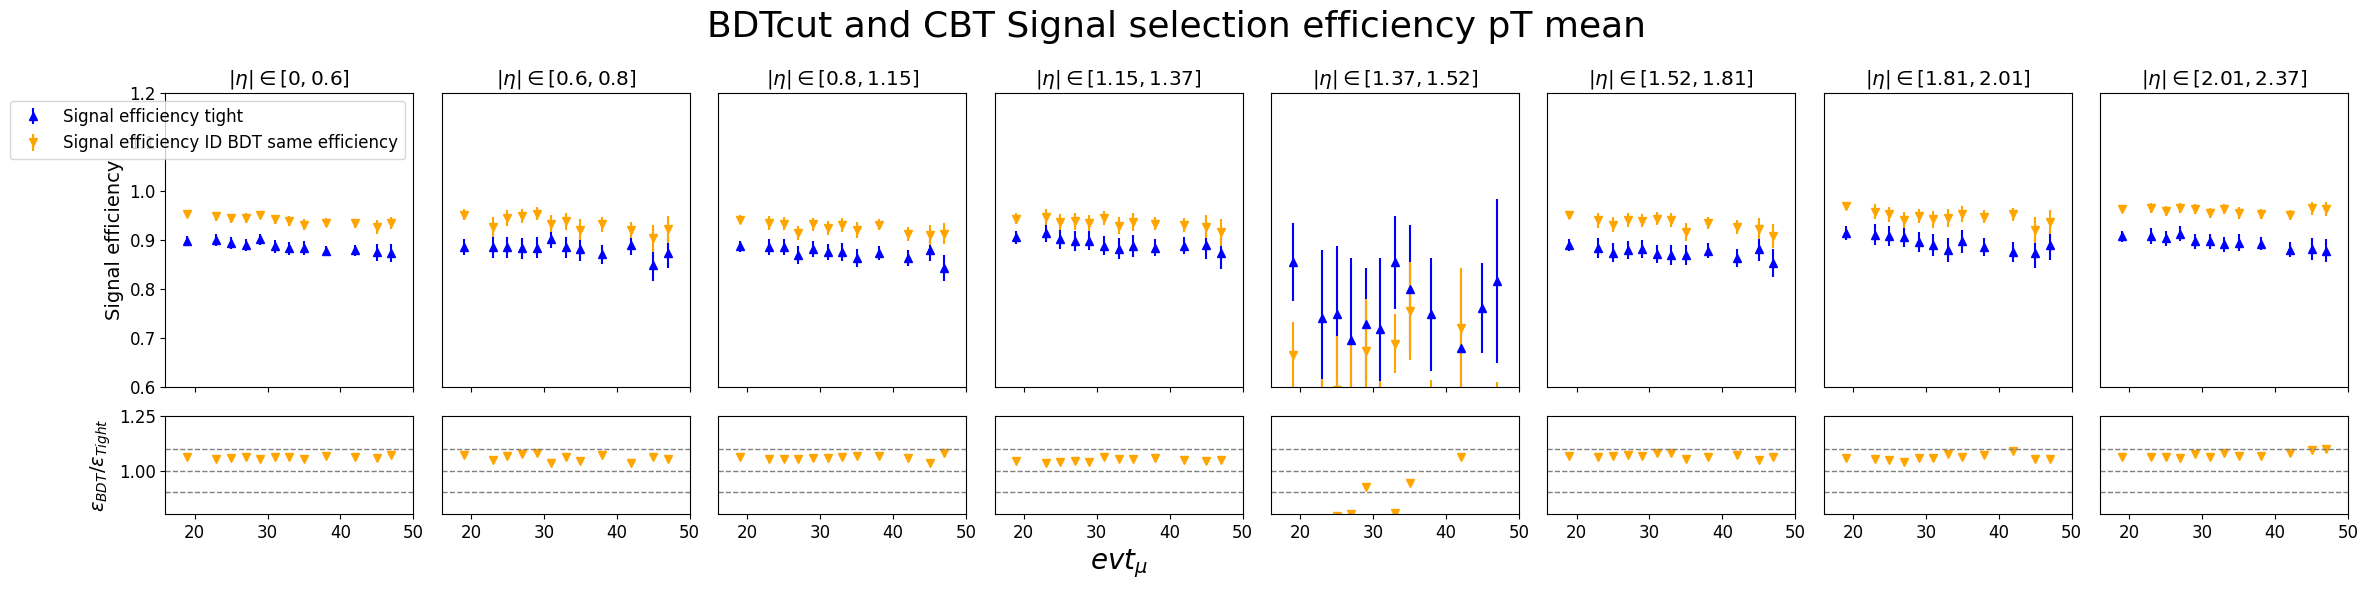

In [30]:
# Tracé des résultats
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24, 10),
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace=0, hspace=0)

# Boucle pour les axes principaux
for i in range(8):
    # Utilisation des tableaux 2D
    ax[i].errorbar(mu_sig, eff_sig_tight_2d[i], efferr_sig_tight_2d[i],
                   fmt="^", label='Signal efficiency tight', color='blue')
    ax[i].errorbar(mu_sig, eff_sig_bdt_2d[i], efferr_sig_bdt_2d[i],
                   fmt="v", label='Signal efficiency ID BDT same efficiency', color='orange')
    
    if i != 0:
        ax[i].set_yticks([])
    
    text = r"$|\eta| \in [{}, {}]$".format(edges_eta[i], edges_eta[i + 1])
    ax[i].set_title(text)
    
    # Ratio des efficacités
    ratio = eff_sig_bdt_2d[i] / eff_sig_tight_2d[i]
    rax[i].plot(mu_sig, ratio, 'v', color='orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 50])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.6, 1.2])
    if i != 0:
        rax[i].set_yticks([])

# Ajout des labels et légendes
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency", fontsize=14)
rax[3].set_xlabel("$evt_{\mu}$", fontsize=20)
ax[0].legend(fontsize=12)
fig.suptitle('BDTcut and CBT Signal selection efficiency pT mean', fontsize=26)


plt.tight_layout()

plt.show()

# Integration over pT

In [31]:
# Intégration sur l'axe 'pt'
den_bkg_integrated = den_bkg.project("eta", "evt_mu")

# Intégration sur l'axe 'pt' pour les données tight
num_bkg_tight_integrated = num_bkg_tight.project("eta", "evt_mu")

# Intégration sur l'axe 'pt' pour les données BDT
num_bkg_bdt_integrated = num_bkg_bdt.project("eta", "evt_mu")

# Calcul de l'efficacité et de l'erreur après intégration pour les données tight
eff_bkg_tight_integrated = num_bkg_tight_integrated / den_bkg_integrated
efferr_bkg_tight_integrated = np.sqrt(eff_bkg_tight_integrated.values() * (1. - eff_bkg_tight_integrated.values()) / den_bkg_integrated.values())

# Calcul de l'efficacité et de l'erreur après intégration pour les données BDT
eff_bkg_bdt_integrated = num_bkg_bdt_integrated / den_bkg_integrated
efferr_bkg_bdt_integrated = np.sqrt(eff_bkg_bdt_integrated.values() * (1. - eff_bkg_bdt_integrated.values()) / den_bkg_integrated.values())

In [46]:
den_bkg

Hist(
  Variable([0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37], name='eta', label='$\\eta$'),
  Variable([20, 25, 30, 35, 40, 45, 50, 65, 490], name='pt', label='$p_T$ [GeV]'),
  Variable([0, 16, 22, 24, 26, 28, 30, 32, 34, 36, 40, 44, 46, 48, 60], name='evt_mu', label='$evt_\\mu$'),
  storage=Double()) # Sum: 175905.0 (186284.0 with flow)

In [45]:
den_bkg_integrated

Hist(
  Variable([0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37], name='eta', label='$\\eta$'),
  Variable([0, 16, 22, 24, 26, 28, 30, 32, 34, 36, 40, 44, 46, 48, 60], name='evt_mu', label='$evt_\\mu$'),
  storage=Double()) # Sum: 175910.0 (186284.0 with flow)

In [50]:
eff_bkg_tight_integrated

Hist(
  Variable([0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37], name='eta', label='$\\eta$'),
  Variable([0, 16, 22, 24, 26, 28, 30, 32, 34, 36, 40, 44, 46, 48, 60], name='evt_mu', label='$evt_\\mu$'),
  storage=Double()) # Sum: 25.34722828418201 (nan with flow)

In [51]:
mu_bkg

array([ 8., 19., 23., 25., 27., 29., 31., 33., 35., 38., 42., 45., 47.,
       54.])

TypeError: object of type 'Hist' has no len()

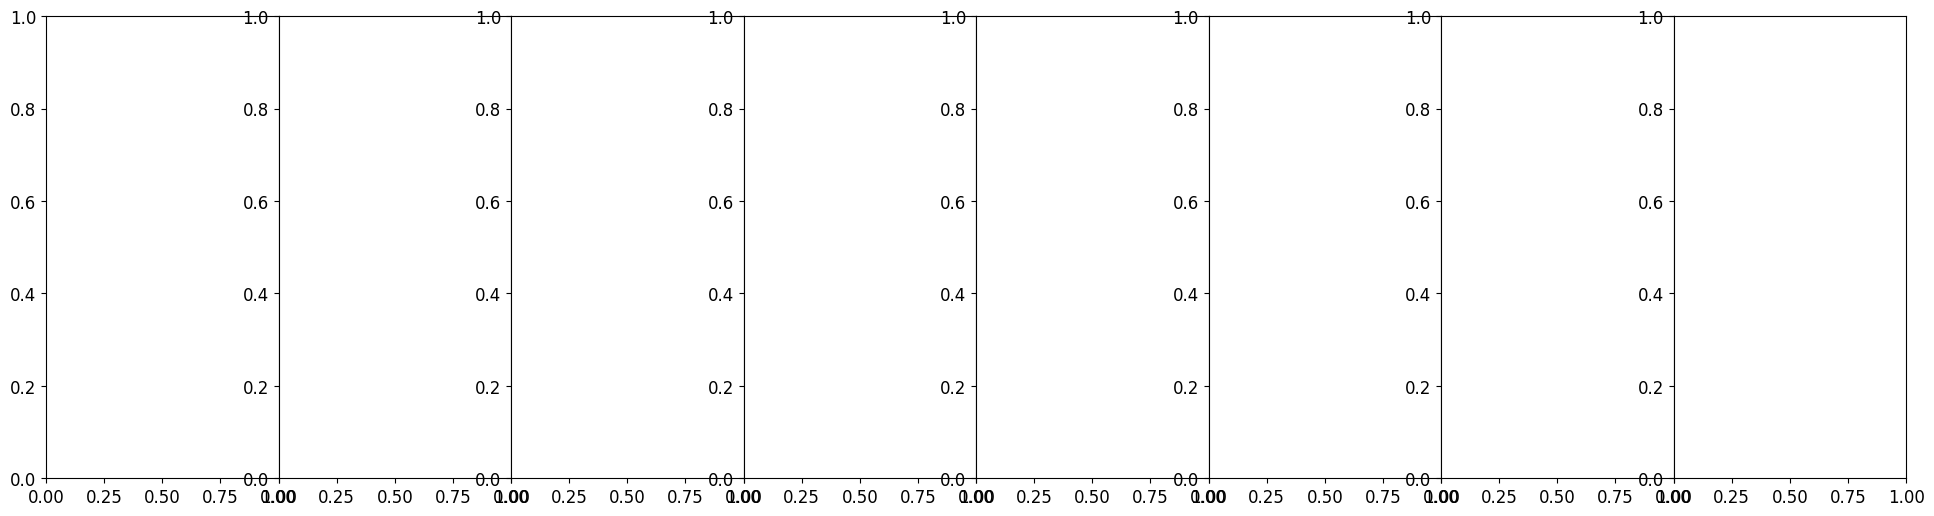

In [55]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu_bkg, [eff_bkg_tight_integrated[j][i] for j in range(len(eff_bkg_tight_integrated))],
                   [efferr_bkg_tight_integrated[j][i] for j in range(len(efferr_bkg_tight_integrated))],
                   fmt=".", label='Background efficiency tight', color = 'blue')
    ax[i].errorbar(mu_bkg,[eff_bkg_bdt_integrated[j][i] for j in range(len(eff_bkg_bdt_integrated))],
                   [efferr_bkg_bdt_integrated[j][i] for j in range(len(efferr_bkg_bdt_integrated))], 
                   fmt="o", fillstyle='none', label='Background efficiency BDT', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0): ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlim([16, 50])
    
ax[0].set_ylabel("Background rejection",  fontsize=14)
ax[3].set_xlabel("$evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)
fig.suptitle('BDTcut and CBT Background rejection efficiency', fontsize=26)

plt.tight_layout()

#plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_rejection_MU_BinETA_BDTsansMU.pdf")
plt.show()

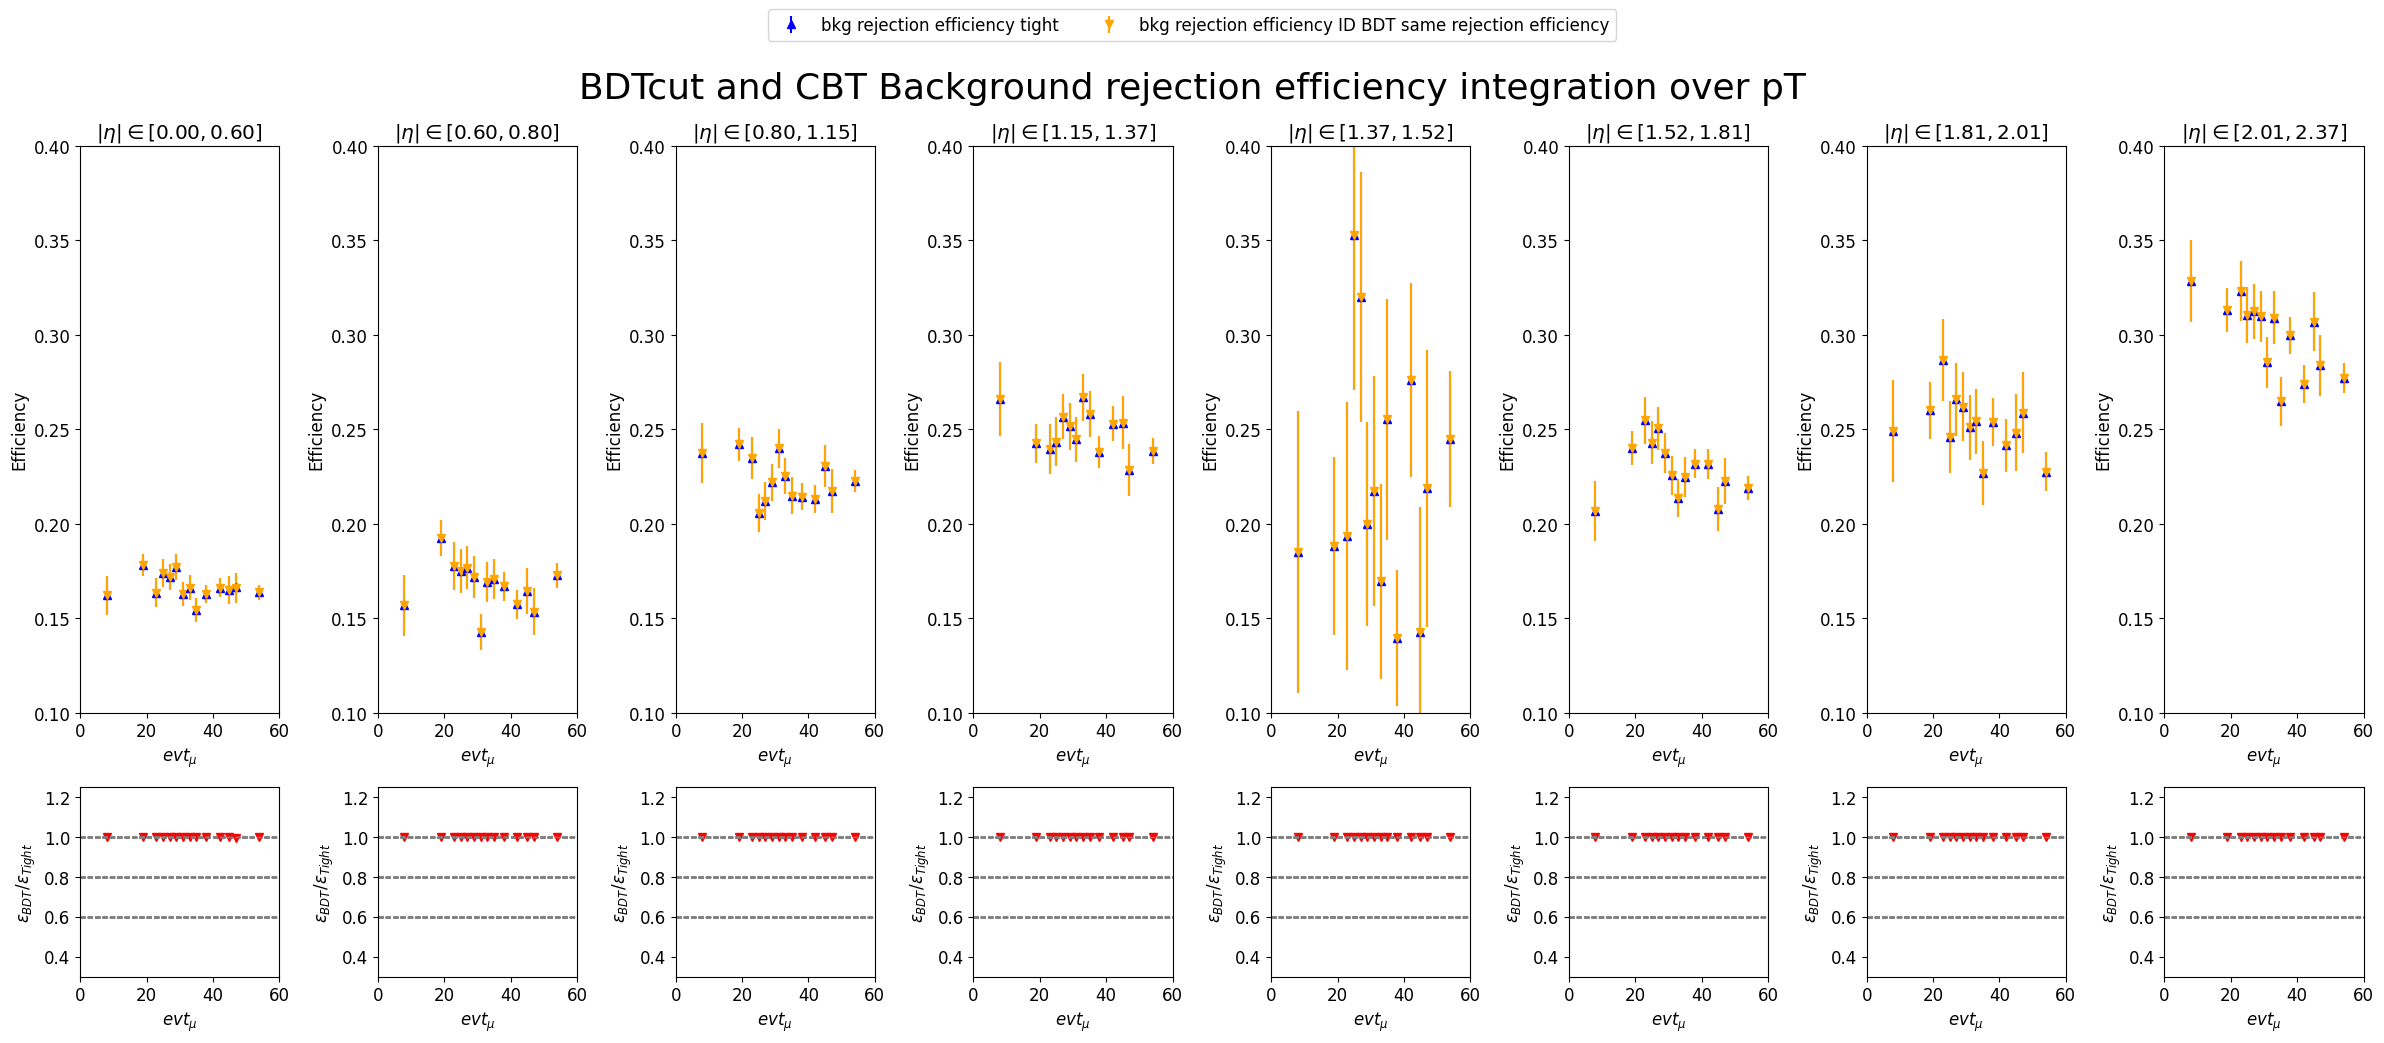

In [32]:
num_eta_bins = len(axis_eta)  
num_mu_bins = len(axis_mu_bkg)  

fig, axs = plt.subplots(nrows=2, ncols=num_eta_bins, figsize=(24, 10), gridspec_kw={"height_ratios": [3, 1]})
fig.subplots_adjust(hspace=0.3, wspace=0.3)



for eta_idx in range(num_eta_bins):
    
    for mu_idx in range(num_mu_bins):
        ax = axs[0, eta_idx]  # pour l'efficacité
        rax = axs[1, eta_idx]  # pour le ratio

        # Sélection données pour indices eta et mu
        eff_data_bkg_tight = eff_bkg_tight_integrated[eta_idx, mu_idx]
        err_data_bkg_tight = efferr_bkg_tight_integrated[eta_idx, mu_idx]
        
        eff_data_bkg_bdt = eff_bkg_bdt_integrated[eta_idx, mu_idx]
        err_data_bkg_bdt = efferr_bkg_bdt_integrated[eta_idx, mu_idx]

        # Errorbar pour l'efficacité tight et BDT
        ax.errorbar(mu_bkg[mu_idx], eff_data_bkg_tight, yerr=err_data_bkg_tight, fmt='^', linestyle='', 
                    color='blue', label='bkg rejection efficiency tight')
        ax.errorbar(mu_bkg[mu_idx], eff_data_bkg_bdt, yerr=err_data_bkg_bdt, fmt='v', linestyle='', 
                    color='orange', label='bkg rejection efficiency ID BDT same rejection efficiency')

        # Ratio
        ratio = eff_data_bkg_bdt / eff_data_bkg_tight
        rax.plot(mu_bkg[mu_idx], ratio, 'v-', color='red')
        rax.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)
        rax.axhline(y=0.6, color='grey', linestyle='--', linewidth=1)
        rax.axhline(y=1, color='grey', linestyle='--', linewidth=1)
        
        if eta_idx == 0 and mu_idx == 0:  
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12)
            
       
        ax.set_title(f"$|\eta| \in [{edges_eta[eta_idx]:.2f}, {edges_eta[eta_idx+1]:.2f}]$")
    
        ax.set_ylim(0.1, 0.4)
        ax.set_xlim([0, 60])
        ax.set_ylabel('Efficiency')
        ax.set_xlabel('$evt_{\mu}$')
        rax.set_ylim(0.3, 1.25)
        rax.set_xlim([0, 60])
        rax.set_ylabel(r'$\epsilon_{BDT}/\epsilon_{Tight}$')
        rax.set_xlabel('$evt_{\mu}$')
        
fig.suptitle('BDTcut and CBT Background rejection efficiency integration over pT', fontsize=26)

        
plt.tight_layout()

#plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_efficiency_MU_BinETA_pT_integer.pdf")

plt.show()


In [33]:
# Intégration sur l'axe 'pt'
den_sig_integrated = den_sig.project("eta", "evt_mu")

# Intégration sur l'axe 'pt' pour les données tight
num_sig_tight_integrated = num_sig_tight.project("eta", "evt_mu")

# Intégration sur l'axe 'pt' pour les données BDT
num_sig_bdt_integrated = num_sig_bdt.project("eta", "evt_mu")

# Calcul de l'efficacité et de l'erreur après intégration pour les données tight
eff_sig_tight_integrated = num_sig_tight_integrated / den_sig_integrated
efferr_sig_tight_integrated = np.sqrt(eff_sig_tight_integrated.values() * (1. - eff_sig_tight_integrated.values()) / den_sig_integrated.values())

# Calcul de l'efficacité et de l'erreur après intégration pour les données BDT
eff_sig_bdt_integrated = num_sig_bdt_integrated / den_sig_integrated
efferr_sig_bdt_integrated = np.sqrt(eff_sig_bdt_integrated.values() * (1. - eff_sig_bdt_integrated.values()) / den_sig_integrated.values())

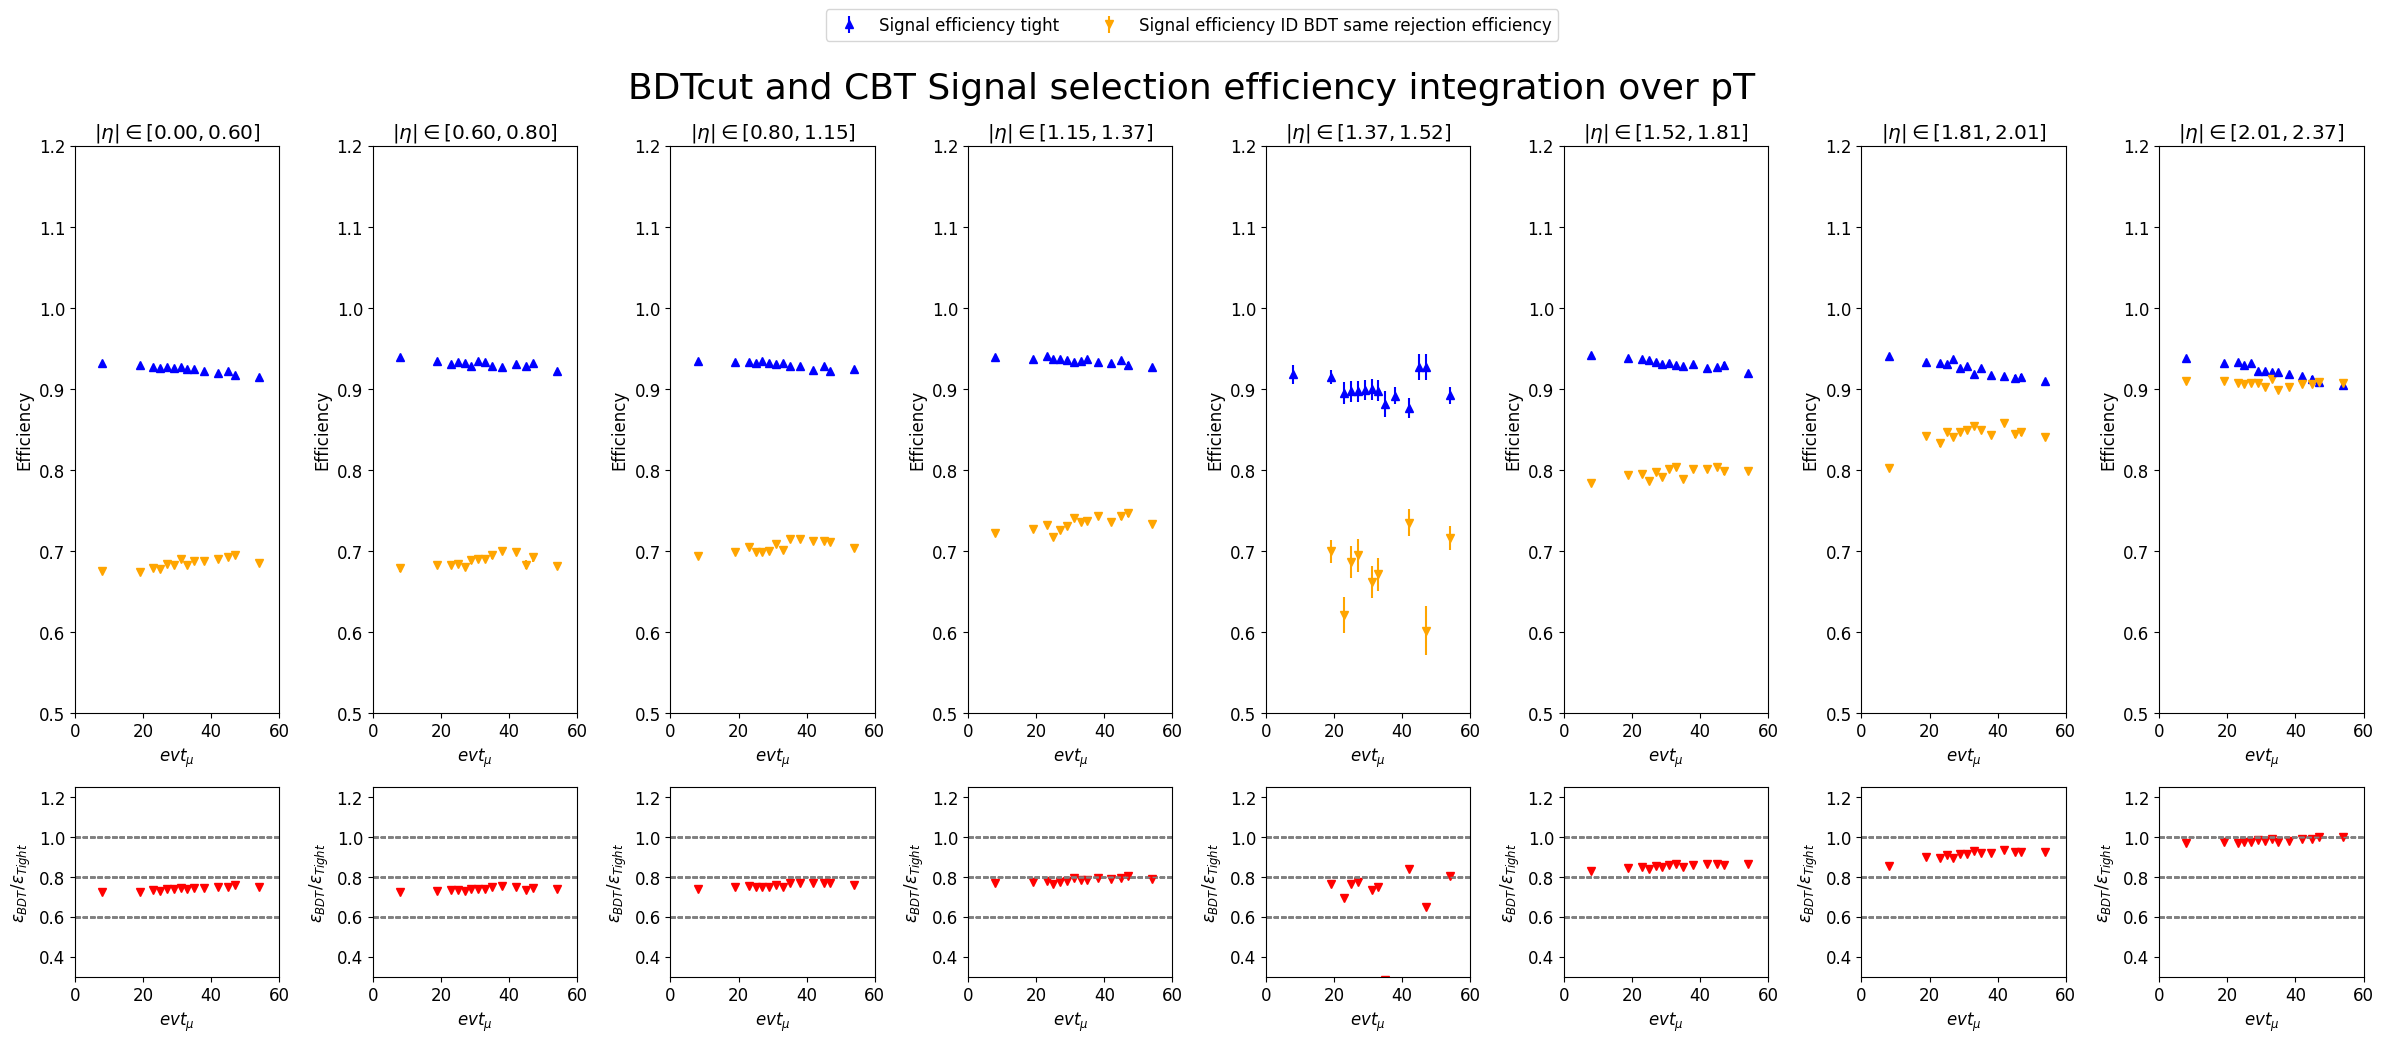

In [34]:
num_eta_bins = len(axis_eta)  
num_mu_bins = len(axis_mu_sig)  

fig, axs = plt.subplots(nrows=2, ncols=num_eta_bins, figsize=(24, 10), gridspec_kw={"height_ratios": [3, 1]})
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for eta_idx in range(num_eta_bins):
    for mu_idx in range(num_mu_bins):
        ax = axs[0, eta_idx]  # Subplot principal pour l'efficacité
        rax = axs[1, eta_idx]  # Subplot pour le ratio

        # Sélection des données pour les indices eta et mu
        eff_data_sig_tight = eff_sig_tight_integrated[eta_idx, mu_idx]
        err_data_sig_tight = efferr_sig_tight_integrated[eta_idx, mu_idx]
        
        eff_data_sig_bdt = eff_sig_bdt_integrated[eta_idx, mu_idx]
        err_data_sig_bdt = efferr_sig_bdt_integrated[eta_idx, mu_idx]

        # Errorbar pour l'efficacité tight et BDT
        ax.errorbar(mu_sig[mu_idx], eff_data_sig_tight, yerr=err_data_sig_tight, fmt='^', linestyle='', 
                    color='blue', label='Signal efficiency tight')
        ax.errorbar(mu_sig[mu_idx], eff_data_sig_bdt, yerr=err_data_sig_bdt, fmt='v', linestyle='', 
                    color='orange', label='Signal efficiency ID BDT same rejection efficiency')

        # Calcul et tracé du ratio
        ratio = eff_data_sig_bdt / eff_data_sig_tight
        rax.plot(mu_sig[mu_idx], ratio, 'v-', color='red')
        rax.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)
        rax.axhline(y=0.6, color='grey', linestyle='--', linewidth=1)
        rax.axhline(y=1, color='grey', linestyle='--', linewidth=1)
        
        if eta_idx == 0 and mu_idx == 0:  
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12)
            
       
        ax.set_title(f"$|\eta| \in [{edges_eta[eta_idx]:.2f}, {edges_eta[eta_idx+1]:.2f}]$")
    
        ax.set_ylim(0.5, 1.2)
        ax.set_xlim([0, 60])
        ax.set_ylabel('Efficiency')
        ax.set_xlabel('$evt_{\mu}$')
        rax.set_ylim(0.3, 1.25)
        rax.set_xlim([0, 60])
        rax.set_ylabel(r'$\epsilon_{BDT}/\epsilon_{Tight}$')
        rax.set_xlabel('$evt_{\mu}$')
        
fig.suptitle('BDTcut and CBT Signal selection efficiency integration over pT', fontsize=26)

plt.tight_layout()
        
#plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_efficiency_MU_BinETA_pT_integer.pdf")

plt.show()


# pT dans bin de Eta integre sur Mu

In [35]:
New_edges_pt_sig = [ 20.,    25.,    30.,    35.,    40.,
                 45.,    50.,    55.,    60.,    65.,    
                 70.,    75.,    80.,    85.,    90.,
                 95.,   100.,   110.,   120.,   140.,   
                145.,   150.,   155.,   160.,   165.,
                175.,   190.,   205.,   230.,   280.,   
                285.,   290.,   300.,   305.,   315.,
                325.,   340.,   355.,   370.,   395.,   
                430.,   490.]

num_eta_bins = len(axis_eta)  

In [36]:
New_axis_pt_sig = hist.axis.Variable(New_edges_pt_sig, name='pt', label=r"$p_T$ [GeV]")

In [37]:
df = df.assign(New_pt_bin_sig = New_axis_pt_sig.index(df['y_pt']))

In [38]:
# Histograms and Axes pour 'mu', 'pt' et 'eta'
New_den_sig = hist.Hist(axis_eta, New_axis_pt_sig, axis_mu_sig).fill(df_sig["y_abs_eta"], df_sig["y_pt"], df_sig["evt_mu"])   #before cut-base
New_den_bkg = hist.Hist(axis_eta, axis_pt_bkg, axis_mu_bkg).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"], df_bkg["evt_mu"])


New_num_sig_tight = hist.Hist(axis_eta, New_axis_pt_sig, axis_mu_sig).fill(df_sig_tight["y_abs_eta"], 
                                                                       df_sig_tight["y_pt"], df_sig_tight["evt_mu"])   #after cut-base
New_num_bkg_tight = hist.Hist(axis_eta, axis_pt_bkg, axis_mu_bkg).fill(df_bkg_tight["y_abs_eta"], 
                                                                       df_bkg_tight["y_pt"], df_bkg_tight["evt_mu"])

New_eff_sig_tight = (New_num_sig_tight/New_den_sig).values()
New_efferr_sig_tight = np.sqrt(New_eff_sig_tight*(1.-New_eff_sig_tight)/New_den_sig.values()) # binomial uncertainty on efficiency

New_eff_bkg_tight = (New_num_bkg_tight/New_den_bkg).values()
New_efferr_bkg_tight = np.sqrt(New_eff_bkg_tight*(1.-New_eff_bkg_tight)/New_den_bkg.values()) # binomial uncertainty on efficiency


In [39]:
#num and efficiency for the BDT

New_df_sig_bdt = df_sig.query('pass_BDTcut_samebkgeff_tight')
New_num_sig_bdt = hist.Hist(axis_eta, New_axis_pt_sig, axis_mu_sig).fill(df_sig_bdt["y_abs_eta"], 
                                                                     df_sig_bdt["y_pt"], df_sig_bdt["evt_mu"])

New_df_bkg_bdt = df_bkg.query('pass_BDTcut_samebkgeff_tight')
New_num_bkg_bdt = hist.Hist(axis_eta, axis_pt_bkg, axis_mu_bkg).fill(df_bkg_bdt["y_abs_eta"], 
                                                                     df_bkg_bdt["y_pt"], df_bkg_bdt["evt_mu"])

New_eff_sig_bdt = (New_num_sig_bdt / New_den_sig).values()
New_efferr_sig_bdt = np.sqrt(New_eff_sig_bdt * (1 - New_eff_sig_bdt) / New_den_sig.values())

New_eff_bkg_bdt = (New_num_bkg_bdt / New_den_bkg).values()
New_efferr_bkg_bdt = np.sqrt(New_eff_bkg_bdt * (1 - New_eff_bkg_bdt) / New_den_bkg.values())

In [40]:
# Intégration sur l'axe 'Mu'

New_den_sig_integrated = New_den_sig.project("eta", "pt")
New_num_sig_tight_integrated = New_num_sig_tight.project("eta", "pt")
New_num_sig_bdt_integrated = New_num_sig_bdt.project("eta", "pt")

# Calcul de l'efficacité et de l'erreur après intégration pour les données tight

New_eff_sig_tight_integrated = New_num_sig_tight_integrated / New_den_sig_integrated
New_efferr_sig_tight_integrated = np.sqrt(New_eff_sig_tight_integrated.values() * (1. - New_eff_sig_tight_integrated.values()) / New_den_sig_integrated.values())

# Calcul de l'efficacité et de l'erreur après intégration pour les données BDT

New_eff_sig_bdt_integrated = New_num_sig_bdt_integrated / New_den_sig_integrated
New_efferr_sig_bdt_integrated = np.sqrt(New_eff_sig_bdt_integrated.values() * (1. - New_eff_sig_bdt_integrated.values()) / New_den_sig_integrated.values())


In [41]:
# Convertir les histogrammes en listes ou arrays pour tracer avec matplotlib
New_pt_sig = New_axis_pt_sig.centers

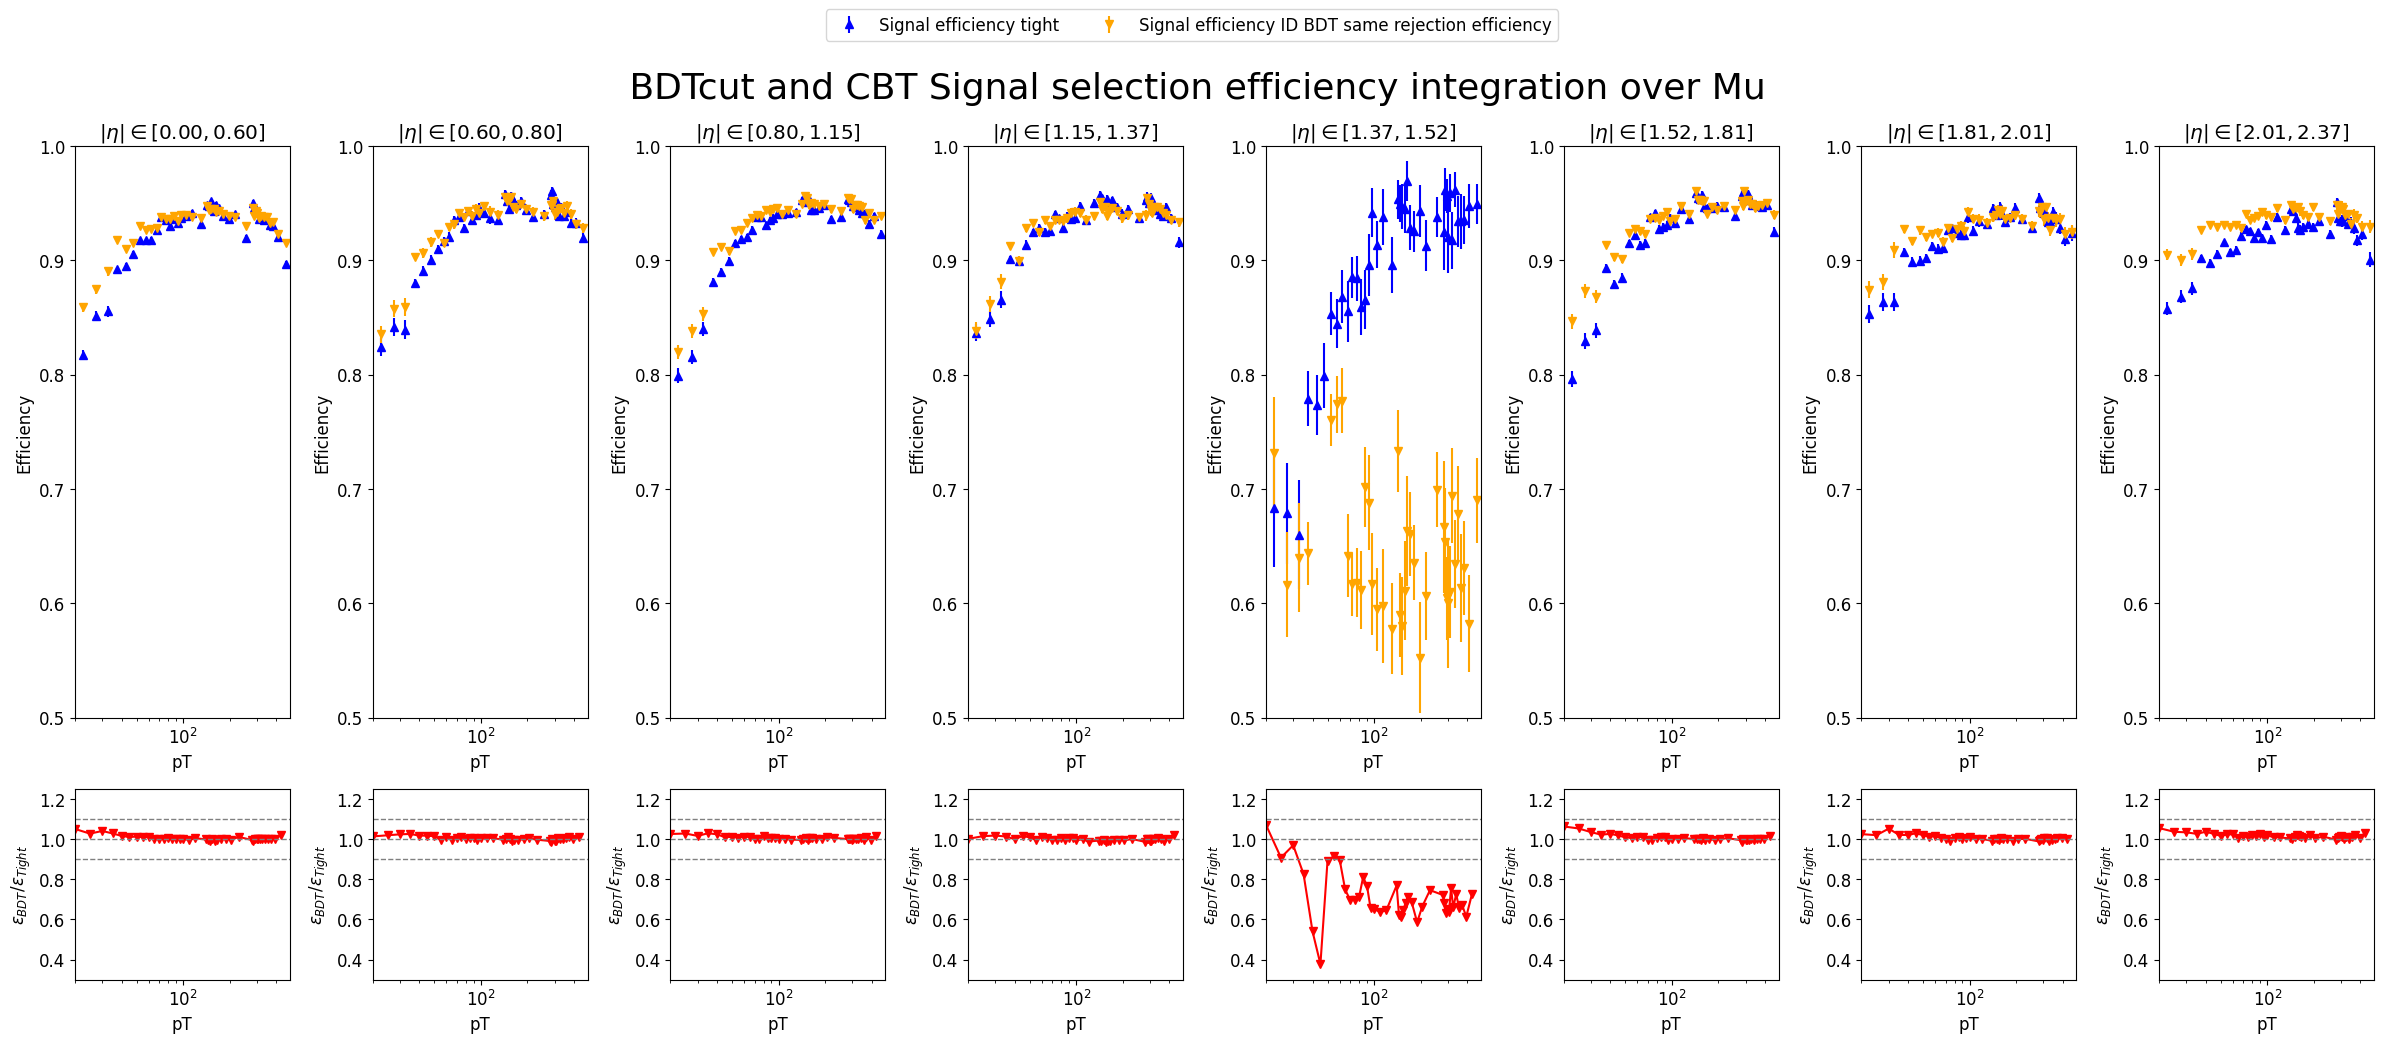

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=num_eta_bins, figsize=(24, 10), gridspec_kw={"height_ratios": [3, 1]})
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for eta_idx in range(num_eta_bins):
    ax = axs[0, eta_idx]  # Subplot principal pour l'efficacité
    rax = axs[1, eta_idx]  # Subplot pour le ratio

    # Sélection des données pour les indices eta
    New_eff_data_sig_tight = New_eff_sig_tight_integrated.values()[eta_idx]
    New_err_data_sig_tight = New_efferr_sig_tight_integrated[eta_idx]
    
    New_eff_data_sig_bdt = New_eff_sig_bdt_integrated.values()[eta_idx]
    New_err_data_sig_bdt = New_efferr_sig_bdt_integrated[eta_idx]

    # Errorbar pour l'efficacité tight et BDT
    ax.errorbar(New_pt_sig, New_eff_data_sig_tight, yerr=New_err_data_sig_tight, fmt='^', linestyle='', 
                color='blue', label='Signal efficiency tight')
    ax.errorbar(New_pt_sig, New_eff_data_sig_bdt, yerr=New_err_data_sig_bdt, fmt='v', linestyle='', 
                color='orange', label='Signal efficiency ID BDT same rejection efficiency')

    # Calcul et tracé du ratio
    ratio = New_eff_data_sig_bdt / New_eff_data_sig_tight
    rax.plot(New_edges_pt_sig[:-1], ratio, 'v-', color='red')
    rax.axhline(y=1, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    
    if eta_idx == 0:  
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12)
        
    ax.set_title(f"$|\eta| \in [{edges_eta[eta_idx]:.2f}, {edges_eta[eta_idx+1]:.2f}]$")
    ax.set_ylim(0.5, 1.0)
    ax.set_xlim([New_edges_pt_sig[0], New_edges_pt_sig[-1]])
    ax.set_ylabel('Efficiency')
    ax.set_xlabel('pT')
    ax.set_xscale('log') 
    rax.set_ylim(0.3, 1.25)
    rax.set_xlim([New_edges_pt_sig[0], New_edges_pt_sig[-1]])
    rax.set_ylabel(r'$\epsilon_{BDT}/\epsilon_{Tight}$')
    rax.set_xlabel('pT')
    rax.set_xscale('log')  
    
fig.suptitle(' BDTcut and CBT Signal selection efficiency integration over Mu', fontsize=26)


plt.tight_layout()

#plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_efficiency_pT_BinETA_Mu_integer.pdf")

plt.show()
